# Tutorial: Reduced Order Modeling with POD-RBF and POD-NN Approaches for Fluid Dynamics

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial8/tutorial.ipynb)

The goal of this tutorial is to demonstrate how to use the **PINA** library to apply a reduced-order modeling technique, as outlined in [1]. These methods share several similarities with machine learning approaches, as they focus on predicting the solution to differential equations, often parametric PDEs, in real-time.

In particular, we will utilize **Proper Orthogonal Decomposition** (POD) in combination with two different regression techniques: **Radial Basis Function Interpolation** (POD-RBF) and **Neural Networks**(POD-NN) [2]. This process involves reducing the dimensionality of the parametric solution manifold through POD and then approximating it in the reduced space using a regression model (either a neural network or an RBF interpolation). In this example, we'll use a simple multilayer perceptron (MLP) as the regression model, but various architectures can be easily substituted.

Let's start with the necessary imports.

In [1]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"


import matplotlib
import matplotlib.pyplot as plt
import torch
import numpy as np
import warnings

from pina import Trainer
from pina.model import FeedForward
from pina.solver import SupervisedSolver
from pina.optim import TorchOptimizer
from pina.problem.zoo import SupervisedProblem
from pina.model.block import PODBlock, RBFBlock

warnings.filterwarnings("ignore")

We utilize the [Smithers](https://github.com/mathLab/Smithers) library to gather the parametric snapshots. Specifically, we use the `NavierStokesDataset` class, which contains a collection of parametric solutions to the Navier-Stokes equations in a 2D L-shaped domain. The parameter in this case is the inflow velocity.

The dataset comprises 500 snapshots of the velocity fields (along the $x$, $y$ axes, and the magnitude), as well as the pressure fields, along with their corresponding parameter values.

To visually inspect the snapshots, let's also plot the data points alongside the reference solution. This reference solution represents the expected output of our model.

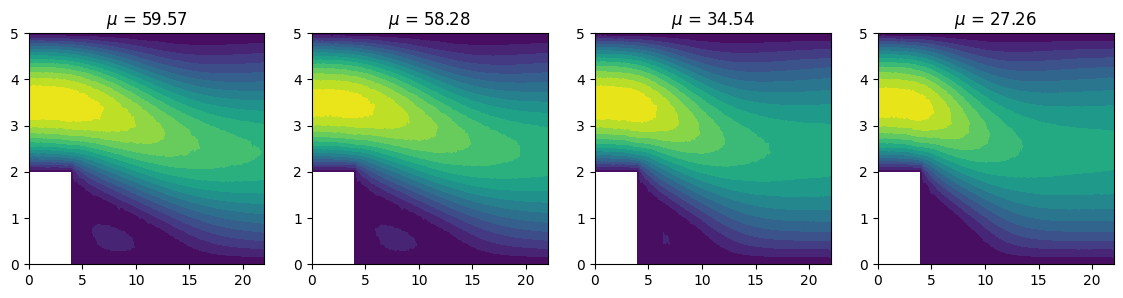

In [2]:
from smithers.dataset import NavierStokesDataset

dataset = NavierStokesDataset()

fig, axs = plt.subplots(1, 4, figsize=(14, 3))
for ax, p, u in zip(axs, dataset.params[:4], dataset.snapshots["mag(v)"][:4]):
    ax.tricontourf(dataset.triang, u, levels=16)
    ax.set_title(f"$\mu$ = {p[0]:.2f}")

The *snapshots*—i.e., the numerical solutions computed for several parameters—and the corresponding parameters are the only data we need to train the model, enabling us to predict the solution for any new test parameter. To properly validate the accuracy, we will split the 500 snapshots into the training dataset (90% of the original data) and the testing dataset (the remaining 10%) inside the `Trainer`.

It is now time to define the problem!

In [3]:
u = torch.tensor(dataset.snapshots["mag(v)"]).float()
p = torch.tensor(dataset.params).float()
problem = SupervisedProblem(input_=p, output_=u)

We can then build a `POD-NN` model (using an MLP architecture as approximation) and compare it with a `POD-RBF` model (using a Radial Basis Function interpolation as approximation).

## POD-NN reduced order model
Let's build the `PODNN` class

In [4]:
class PODNN(torch.nn.Module):
    def __init__(self, pod_rank, layers, func):
        super().__init__()
        self.pod = PODBlock(pod_rank)
        self.nn = FeedForward(
            input_dimensions=1,
            output_dimensions=pod_rank,
            layers=layers,
            func=func,
        )

    def forward(self, x):
        coefficents = self.nn(x)
        return self.pod.expand(coefficents)

    def fit_pod(self, x):
        self.pod.fit(x)

We highlight that the POD modes are directly computed by means of the singular value decomposition (SVD) over the input data, and not trained using the backpropagation approach. Only the weights of the MLP are actually trained during the optimization loop.

In [5]:
pod_nn = PODNN(pod_rank=20, layers=[10, 10, 10], func=torch.nn.Tanh)
pod_nn_stokes = SupervisedSolver(
    problem=problem,
    model=pod_nn,
    optimizer=TorchOptimizer(torch.optim.Adam, lr=0.0001),
    use_lt=False,
)

Before starting, we need to fit the POD basis on the training dataset. This can be easily done in **PINA** as well:

In [ ]:
trainer = Trainer(
    solver=pod_nn_stokes,
    max_epochs=1000,
    batch_size=None,
    accelerator="cpu",
    train_size=0.9,
    val_size=0.0,
    test_size=0.1,
)

# fit the pod basis
trainer.data_module.setup("fit")  # set up the dataset
train_data = trainer.data_module.train_dataset.get_all_data()
x_train = train_data["data"]["target"]  # extract data for training
pod_nn.fit_pod(x=x_train)

# now train
trainer.train()

Done! Now that the computationally expensive part is over, we can load the model in the future to infer new parameters (simply by loading the checkpoint file automatically created by `Lightning`) or test its performances. We measure the relative error for both the training and test datasets, printing the mean error.

In [7]:
# extract train and test data
trainer.data_module.setup("test")  # set up the dataset
p_train = trainer.data_module.train_dataset.conditions_dict["data"]["input"]
u_train = trainer.data_module.train_dataset.conditions_dict["data"]["target"]
p_test = trainer.data_module.test_dataset.conditions_dict["data"]["input"]
u_test = trainer.data_module.test_dataset.conditions_dict["data"]["target"]

# compute statistics
u_test_nn = pod_nn_stokes(p_test)
u_train_nn = pod_nn_stokes(p_train)

relative_error_train = torch.norm(u_train_nn - u_train) / torch.norm(u_train)
relative_error_test = torch.norm(u_test_nn - u_test) / torch.norm(u_test)

print("Error summary for POD-NN model:")
print(f"  Train: {relative_error_train.item():e}")
print(f"  Test:  {relative_error_test.item():e}")

Error summary for POD-NN model:
  Train: 4.385251e-01
  Test:  4.857099e-01


## POD-RBF Reduced Order Model

Next, we define the model we want to use, incorporating the `PODBlock` and `RBFBlock` objects.

In [8]:
class PODRBF(torch.nn.Module):
    def __init__(self, pod_rank, rbf_kernel):
        super().__init__()
        self.pod = PODBlock(pod_rank)
        self.rbf = RBFBlock(kernel=rbf_kernel)

    def forward(self, x):
        coefficents = self.rbf(x)
        return self.pod.expand(coefficents)

    def fit(self, p, x):
        self.pod.fit(x)
        self.rbf.fit(p, self.pod.reduce(x))

We can now fit the model and use it to predict the required field for unseen parameter values. Note that this model does not require a `Trainer` since it does not include any neural networks or learnable parameters.

In [9]:
pod_rbf = PODRBF(pod_rank=20, rbf_kernel="thin_plate_spline")
pod_rbf.fit(p_train, u_train)

Compute errors

In [10]:
u_test_rbf = pod_rbf(p_test)
u_train_rbf = pod_rbf(p_train)

relative_error_train = torch.norm(u_train_rbf - u_train) / torch.norm(u_train)
relative_error_test = torch.norm(u_test_rbf - u_test) / torch.norm(u_test)

print("Error summary for POD-RBF model:")
print(f"  Train: {relative_error_train.item():e}")
print(f"  Test:  {relative_error_test.item():e}")

Error summary for POD-RBF model:
  Train: 5.860014e-05
  Test:  7.156110e-05


## POD-RBF vs POD-NN

We can compare the solutions predicted by the `POD-RBF` and the `POD-NN` models with the original reference solution. By plotting these predicted solutions against the true solution, we can observe how each model performs.

### Observations:
- **POD-RBF**: The solution predicted by the `POD-RBF` model typically offers a smooth approximation for the parametric solution, as RBF interpolation is well-suited for capturing smooth variations.
- **POD-NN**: The `POD-NN` model, while more flexible due to the neural network architecture, may show some discrepancies—especially for low velocities or in regions where the training data is sparse. However, with longer training times and adjustments in the network architecture, we can improve the predictions.

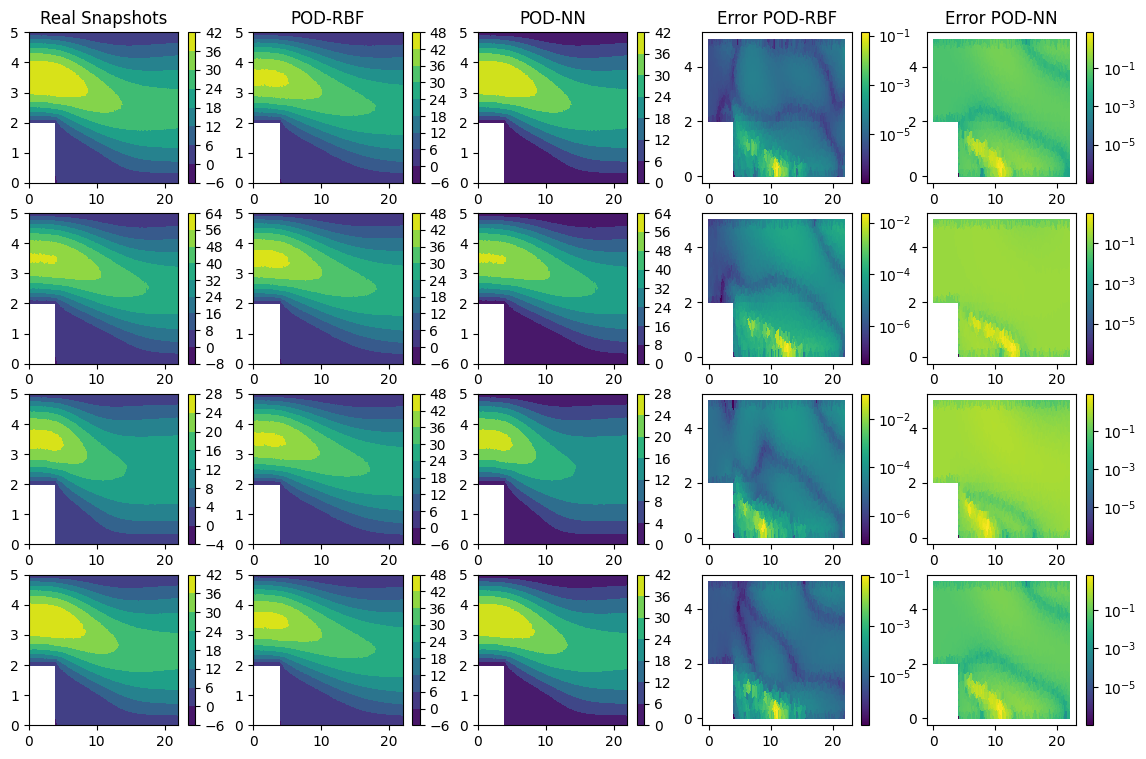

In [11]:
idx = torch.randint(0, len(u_test), (4,))
u_idx_rbf = pod_rbf(p_test[idx])
u_idx_nn = pod_nn_stokes(p_test[idx])


fig, axs = plt.subplots(4, 5, figsize=(14, 9))

relative_error_rbf = np.abs(u_test[idx] - u_idx_rbf.detach())
relative_error_rbf = np.where(
    u_test[idx] < 1e-7, 1e-7, relative_error_rbf / u_test[idx]
)

relative_error_nn = np.abs(u_test[idx] - u_idx_nn.detach())
relative_error_nn = np.where(
    u_test[idx] < 1e-7, 1e-7, relative_error_nn / u_test[idx]
)

for i, (idx_, rbf_, nn_, rbf_err_, nn_err_) in enumerate(
    zip(idx, u_idx_rbf, u_idx_nn, relative_error_rbf, relative_error_nn)
):

    axs[0, 0].set_title(f"Real Snapshots")
    axs[0, 1].set_title(f"POD-RBF")
    axs[0, 2].set_title(f"POD-NN")
    axs[0, 3].set_title(f"Error POD-RBF")
    axs[0, 4].set_title(f"Error POD-NN")

    cm = axs[i, 0].tricontourf(
        dataset.triang, rbf_.detach()
    )  # POD-RBF prediction
    plt.colorbar(cm, ax=axs[i, 0])

    cm = axs[i, 1].tricontourf(
        dataset.triang, nn_.detach()
    )  # POD-NN prediction
    plt.colorbar(cm, ax=axs[i, 1])

    cm = axs[i, 2].tricontourf(dataset.triang, u_test[idx_].flatten())  # Truth
    plt.colorbar(cm, ax=axs[i, 2])

    cm = axs[i, 3].tripcolor(
        dataset.triang, rbf_err_, norm=matplotlib.colors.LogNorm()
    )  # Error for POD-RBF
    plt.colorbar(cm, ax=axs[i, 3])

    cm = axs[i, 4].tripcolor(
        dataset.triang, nn_err_, norm=matplotlib.colors.LogNorm()
    )  # Error for POD-NN
    plt.colorbar(cm, ax=axs[i, 4])

plt.show()

## What's Next?

Congratulations on completing this tutorial using **PINA** to apply reduced order modeling techniques with **POD-RBF** and **POD-NN**! There are several directions you can explore next:

1. **Extend to More Complex Problems**: Try using more complex parametric domains or PDEs. For example, you can explore Navier-Stokes equations in 3D or more complex boundary conditions.

2. **Combine POD with Deep Learning Techniques**: Investigate hybrid methods, such as combining **POD-NN** with convolutional layers or recurrent layers, to handle time-dependent problems or more complex spatial dependencies.

3. **Evaluate Performance on Larger Datasets**: Work with larger datasets to assess how well these methods scale. You may want to test on datasets from simulations or real-world problems.

4. **Hybrid Models with Physics Informed Networks (PINN)**: Integrate **POD** models with PINN frameworks to include physics-based regularization in your model and improve predictions for more complex scenarios, such as turbulent fluid flow.

5. **...and many more!**: The potential applications of reduced order models are vast, ranging from material science simulations to real-time predictions in engineering applications.

For more information and advanced tutorials, refer to the [PINA Documentation](https://mathlab.github.io/PINA/).

### References
1. Rozza G., Stabile G., Ballarin F. (2022). Advanced Reduced Order Methods and Applications in Computational Fluid Dynamics, Society for Industrial and Applied Mathematics. 
2. Hesthaven, J. S., & Ubbiali, S. (2018). Non-intrusive reduced order modeling of nonlinear problems using neural networks. Journal of Computational Physics, 363, 55-78.